# CS 145 COVID Prediction

## Loading Data

First we need to load the data, which is stored in CSV files separated by date

In [ ]:
!pip install statsmodels
!pip install pmdarima
from google.colab import drive
import numpy as np
import pandas as pd
import glob
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
# grab filepaths for every csv file
datapath = '/content/drive/MyDrive/CS145-COVID-master.zip (Unzipped Files)/CS145-COVID-master/data/csse_covid_19_daily_reports_us/*.csv'
datafiles = np.array(glob.glob(datapath))
print(datafiles[138:142])

['/content/drive/MyDrive/CS145-COVID-master.zip (Unzipped Files)/CS145-COVID-master/data/csse_covid_19_daily_reports_us/08-28-2020.csv'
 '/content/drive/MyDrive/CS145-COVID-master.zip (Unzipped Files)/CS145-COVID-master/data/csse_covid_19_daily_reports_us/08-29-2020.csv'
 '/content/drive/MyDrive/CS145-COVID-master.zip (Unzipped Files)/CS145-COVID-master/data/csse_covid_19_daily_reports_us/08-30-2020.csv'
 '/content/drive/MyDrive/CS145-COVID-master.zip (Unzipped Files)/CS145-COVID-master/data/csse_covid_19_daily_reports_us/08-31-2020.csv']


In [ ]:
# init giant df
data = pd.read_csv(datafiles[0])
# read and append each csv to the master df
for i in range(1, len(datafiles)):
    df = pd.read_csv(datafiles[i])
    data = data.append(df, ignore_index = True)
# only keep 50 states
data.drop(data[data.Province_State.isin(['Diamond Princess', 'District of Columbia', 'Grand Princess', 'Guam', 'Puerto Rico', 'American Samoa', 'Northern Mariana Islands', 'Recovered', 'Virgin Islands'])].index, inplace = True)
data.drop(columns = ['Country_Region', 'FIPS', 'UID', 'ISO3'], inplace = True)
data['Last_Update'] = data['Last_Update'].astype('datetime64[ns]')
data = data.reset_index(drop=True)
data.loc[48:52, ]

,Province_State,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate,Total_Test_Results,Case_Fatality_Ratio
48,Wisconsin,2020-04-12 23:18:15,44.2685,-89.6165,3341,144,NaN,3197.0,64.565739,39257.0,974.0,4.310087,758.652263,29.152948,NaN,NaN
49,Wyoming,2020-04-12 23:18:15,42.7560,-107.3025,270,0,137.0,270.0,54.299735,5459.0,40.0,0.000000,1097.860188,14.814815,NaN,NaN
50,Alabama,2020-04-13 23:07:54,32.3182,-86.9023,3870,99,NaN,3635.0,79.634933,29182.0,457.0,2.651312,622.363852,12.238886,NaN,NaN
51,Alaska,2020-04-13 23:07:54,61.3707,-152.4044,277,8,85.0,269.0,46.340521,7830.0,32.0,2.888087,1309.914362,11.552347,NaN,NaN
52,Arizona,2020-04-13 23:07:54,33.7298,-111.4312,3705,122,NaN,3583.0,50.901828,43347.0,525.0,3.292848,595.530778,14.170040,NaN,NaN


## Data Cleaning

In [ ]:
data = pd.concat([data, pd.get_dummies(data['Province_State'])], axis = 1)
statenames = np.unique(data['Province_State'])
#data.drop(columns = ['Province_State'], inplace = True)
names = list(data.columns.values)
timestamps = data['Last_Update']
states = data['Province_State']
data.head()

,Province_State,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate,Total_Test_Results,Case_Fatality_Ratio,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Ohio,Oklahoma,Oregon,Pennsylvania,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,Alabama,2020-04-12 23:18:15,32.3182,-86.9023,3667,93,NaN,3470.0,75.988020,21583.0,437.0,2.610160,460.300152,12.264945,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Alaska,2020-04-12 23:18:15,61.3707,-152.4044,272,8,66.0,264.0,45.504049,8038.0,31.0,2.941176,1344.711576,11.397059,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Arizona,2020-04-12 23:18:15,33.7298,-111.4312,3542,115,NaN,3427.0,48.662422,42109.0,NaN,3.246753,578.522286,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Arkansas,2020-04-12 23:18:15,34.9697,-92.3731,1280,27,367.0,1253.0,49.439423,19722.0,130.0,2.109375,761.753354,10.156250,NaN,NaN,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,California,2020-04-12 23:18:15,36.1162,-119.6816,22795,640,NaN,22155.0,58.137726,190328.0,5234.0,2.812020,485.423868,22.961176,NaN,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


We impute NA values using KNN with k = 10.

In [ ]:
imputer = KNNImputer(n_neighbors=10, weights="uniform")
data = pd.DataFrame(data = imputer.fit_transform(data.drop(columns = ['Province_State', 'Last_Update'])), columns = names[2:])
data = pd.concat([states, timestamps, data], axis = 1)
data.head()

,Province_State,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate,Total_Test_Results,Case_Fatality_Ratio,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Ohio,Oklahoma,Oregon,Pennsylvania,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,Alabama,2020-04-12 23:18:15,32.3182,-86.9023,3667.0,93.0,834.1,3470.0,75.988020,21583.0,437.0,2.610160,460.300152,12.264945,150229.1,0.633004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Alaska,2020-04-12 23:18:15,61.3707,-152.4044,272.0,8.0,66.0,264.0,45.504049,8038.0,31.0,2.941176,1344.711576,11.397059,150229.1,0.633004,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Arizona,2020-04-12 23:18:15,33.7298,-111.4312,3542.0,115.0,1378.2,3427.0,48.662422,42109.0,735.6,3.246753,578.522286,18.669261,150229.1,0.633004,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Arkansas,2020-04-12 23:18:15,34.9697,-92.3731,1280.0,27.0,367.0,1253.0,49.439423,19722.0,130.0,2.109375,761.753354,10.156250,150229.1,0.633004,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,California,2020-04-12 23:18:15,36.1162,-119.6816,22795.0,640.0,4283.8,22155.0,58.137726,190328.0,5234.0,2.812020,485.423868,22.961176,151343.2,0.636961,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Additional Features

We will hard code each state's overall political stance in 2020, with 3 indicating safe, 2 indicating likely, 1 indicating leaning, and 0 indicating none. Thus the parameters "dem" and "rep" are ordinal while "swing" is a dummy variable. Because Maine and Nebraska allow split voting, we will consider Maine likely democratic and Nebraska likely republican. The source of the data is from https://www.270towin.com/

We will also include whether a state has enacted a mandatory mask mandate, the data for which is from [Axios](https://www.axios.com/states-face-coverings-mandatory-a0e2fe35-5b7b-458e-9d28-3f6cdb1032fb.html). This will be dummy coded.

In [ ]:
dem = [0, 0, 1, 0, 3, 2, 3, 3, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 2, 3, 3, 1, 2, 0, 0, 0, 0, 1, 1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 3, 0, 0, 0, 0, 0, 3, 2, 3, 0, 1, 0]
rep = [3, 2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 2, 3, 3, 0, 0, 0, 0, 0, 3, 2, 2, 2, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 2, 3, 3, 1, 2, 0, 0, 0, 3, 0, 3]
swing = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
mask = [1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0]

In [ ]:
# repeats an array, e.gg [1,2,3] 2 times is [1,2,3,1,2,3]
def repeat(dat, times):
    temp = dat
    for i in range(int(times) - 1):
        temp = np.append(temp, dat)
    return temp

times = data.shape[0] / 50
data['dem'] = repeat(dem, times)
data['rep'] = repeat(rep, times)
data['swing'] = repeat(swing, times)
data['mask'] = repeat(mask, times)

In [ ]:
data_sort = data[['Province_State', 'Last_Update', 'Confirmed']].sort_values(by = ['Province_State', 'Last_Update'])
cols = data_sort[['Province_State', 'Last_Update']].loc[data_sort['Province_State'] == 'Alabama']
new = data_sort['Confirmed'].loc[data_sort['Province_State'] == 'Alabama']
new = pd.Series(np.append(new.iloc[0], new.iloc[0:len(new) - 1]), index = data_sort.loc[data_sort['Province_State'] == 'Alabama'].index)
df = pd.concat([cols, data_sort['Confirmed'].loc[data_sort['Province_State'] == 'Alabama'] - new], axis = 1)
df.columns.values[2] = 'New_Confirmed'

for state in statenames[1:len(statenames)]:
    cols = data_sort[['Province_State', 'Last_Update']].loc[data_sort['Province_State'] == state]
    new = data_sort['Confirmed'].loc[data_sort['Province_State'] == state]
    new = pd.Series(np.append(new.iloc[0], new.iloc[0:len(new) - 1]), index = data_sort.loc[data_sort['Province_State'] == state].index)
    temp = pd.concat([cols, data_sort['Confirmed'].loc[data_sort['Province_State'] == state] - new], axis = 1)
    temp.columns.values[2] = 'New_Confirmed'
    df = df.append(temp)

data = pd.concat([data, df.sort_values(by = ['Last_Update', 'Province_State'])[['New_Confirmed']]], axis = 1)      

In [ ]:
data_sort = data[['Province_State', 'Last_Update', 'Deaths']].sort_values(by = ['Province_State', 'Last_Update'])
cols = data_sort[['Province_State', 'Last_Update']].loc[data_sort['Province_State'] == 'Alabama']
new = data_sort['Deaths'].loc[data_sort['Province_State'] == 'Alabama']
new = pd.Series(np.append(new.iloc[0], new.iloc[0:len(new) - 1]), index = data_sort.loc[data_sort['Province_State'] == 'Alabama'].index)
df = pd.concat([cols, data_sort['Deaths'].loc[data_sort['Province_State'] == 'Alabama'] - new], axis = 1)
df.columns.values[2] = 'New_Deaths'

for state in statenames[1:len(statenames)]:
    cols = data_sort[['Province_State', 'Last_Update']].loc[data_sort['Province_State'] == state]
    new = data_sort['Deaths'].loc[data_sort['Province_State'] == state]
    new = pd.Series(np.append(new.iloc[0], new.iloc[0:len(new) - 1]), index = data_sort.loc[data_sort['Province_State'] == state].index)
    temp = pd.concat([cols, data_sort['Deaths'].loc[data_sort['Province_State'] == state] - new], axis = 1)
    temp.columns.values[2] = 'New_Deaths'
    df = df.append(temp)

data = pd.concat([data, df.sort_values(by = ['Last_Update', 'Province_State'])[['New_Deaths']]], axis = 1)    
data.head()

,Province_State,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate,Total_Test_Results,Case_Fatality_Ratio,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Ohio,Oklahoma,Oregon,Pennsylvania,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming,dem,rep,swing,mask,New_Confirmed,New_Deaths
0,Alabama,2020-04-12 23:18:15,32.3182,-86.9023,3667.0,93.0,834.1,3470.0,75.988020,21583.0,437.0,2.610160,460.300152,12.264945,150229.1,0.633004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3,0,1,0.0,0.0
1,Alaska,2020-04-12 23:18:15,61.3707,-152.4044,272.0,8.0,66.0,264.0,45.504049,8038.0,31.0,2.941176,1344.711576,11.397059,150229.1,0.633004,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2,0,0,0.0,0.0
2,Arizona,2020-04-12 23:18:15,33.7298,-111.4312,3542.0,115.0,1378.2,3427.0,48.662422,42109.0,735.6,3.246753,578.522286,18.669261,150229.1,0.633004,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0.0,0.0
3,Arkansas,2020-04-12 23:18:15,34.9697,-92.3731,1280.0,27.0,367.0,1253.0,49.439423,19722.0,130.0,2.109375,761.753354,10.156250,150229.1,0.633004,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3,0,1,0.0,0.0
4,California,2020-04-12 23:18:15,36.1162,-119.6816,22795.0,640.0,4283.8,22155.0,58.137726,190328.0,5234.0,2.812020,485.423868,22.961176,151343.2,0.636961,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0,0,1,0.0,0.0


Next we split the data into training and testing sets.

In [ ]:
train = data.drop(data[data.Last_Update.astype('datetime64[ns]') > '2020-09-01'].index)
new_train = data.drop(data[data.Last_Update.astype('datetime64[ns]') > '2020-11-01'].index)
#train.drop(columns = "Last_Update", inplace = True)
test = data.drop(data[(data.Last_Update.astype('datetime64[ns]') <= '2020-09-01')].index)

test.drop(test[(test.Last_Update.astype('datetime64[ns]') > '2020-09-27')].index, inplace = True)
new_test = data.drop(data[(data.Last_Update.astype('datetime64[ns]') <= '2020-11-01')].index)
#test.drop(columns = "Last_Update", inplace = True)

In [ ]:
train.head()

,Province_State,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate,Total_Test_Results,Case_Fatality_Ratio,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Ohio,Oklahoma,Oregon,Pennsylvania,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming,dem,rep,swing,mask,New_Confirmed,New_Deaths
0,Alabama,2020-04-12 23:18:15,32.3182,-86.9023,3667.0,93.0,834.1,3470.0,75.988020,21583.0,437.0,2.610160,460.300152,12.264945,150229.1,0.633004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3,0,1,0.0,0.0
1,Alaska,2020-04-12 23:18:15,61.3707,-152.4044,272.0,8.0,66.0,264.0,45.504049,8038.0,31.0,2.941176,1344.711576,11.397059,150229.1,0.633004,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2,0,0,0.0,0.0
2,Arizona,2020-04-12 23:18:15,33.7298,-111.4312,3542.0,115.0,1378.2,3427.0,48.662422,42109.0,735.6,3.246753,578.522286,18.669261,150229.1,0.633004,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0.0,0.0
3,Arkansas,2020-04-12 23:18:15,34.9697,-92.3731,1280.0,27.0,367.0,1253.0,49.439423,19722.0,130.0,2.109375,761.753354,10.156250,150229.1,0.633004,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3,0,1,0.0,0.0
4,California,2020-04-12 23:18:15,36.1162,-119.6816,22795.0,640.0,4283.8,22155.0,58.137726,190328.0,5234.0,2.812020,485.423868,22.961176,151343.2,0.636961,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0,0,1,0.0,0.0


In [ ]:
train.to_csv('cleaned_train.csv')
test.to_csv('cleaned_test.csv')
new_train.to_csv('new_train.csv')
new_test.to_csv('new_test.csv')

## LSTM Predictions

Followed tensorflow tutorial here: https://www.tensorflow.org/tutorials/structured_data/time_series#the_weather_dataset

First split into training, validation, and testing sets, and standardize values. Start with one state (California):

In [ ]:
import os
import datetime

import IPython
import IPython.display
#import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

Supress warnings from tensorflow

In [ ]:
import logging
def set_tf_loglevel(level):
    if level >= logging.FATAL:
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    if level >= logging.ERROR:
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
    if level >= logging.WARNING:
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
    else:
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
    logging.getLogger('tensorflow').setLevel(level)
set_tf_loglevel(logging.FATAL)

In [ ]:
df_all = pd.read_csv('cleaned_train.csv', index_col = 0)
#print(df[['New_Confirmed', 'New_Deaths']])
df_all = df_all.loc[df_all['Province_State'] == 'California']
df = df_all[['New_Confirmed', 'New_Deaths']]
#print(len(df))
column_indices = {name: i for i, name in enumerate(df.columns)}
n = len(df)
p = 26
train_df = df[0:int(n - 2*p)]
val_df = df[int(n - 2*p):int(n - p)]
test_df = df[int(n - p):]

train_df.describe()

,New_Confirmed,New_Deaths
count,89.000000,89.000000
mean,3142.573034,69.876404
std,2391.741895,30.607790
min,0.000000,0.000000
25%,1649.000000,50.000000
50%,2295.000000,72.000000
75%,3570.000000,88.000000
max,12977.000000,145.000000


In [ ]:
num_features = df.shape[1]

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Define custom classes from tutorial

In [ ]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
        train_df=train_df, val_df=val_df, test_df=test_df,
        label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    #print(self.column_indices)
    #print(self.label_columns)
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

        plt.xlabel('Time [h]')

WindowGenerator.plot = plot

def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

MAX_EPOCHS = 20

def compile_and_fit(model, window, maxepoch = MAX_EPOCHS, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=maxepoch,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [ ]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup

def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the lstm state
    prediction, state = self.warmup(inputs)

    # Insert the first prediction
    predictions.append(prediction)

    # Run the rest of the prediction steps
    for n in range(1, self.out_steps):
        # Use the last prediction as input.
        x = prediction
        # Execute one lstm step.
        x, state = self.lstm_cell(x, states=state,
                                  training=training)
        # Convert the lstm output to a prediction.
        prediction = self.dense(x)
        # Add the prediction to the output
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

FeedBack.call = call

Train LSTM model and predict for a specific state, and print out MAPE at the end

[[2094.795      72.40353 ]
 [2224.825      71.89281 ]
 [2330.1943     71.095146]
 [2388.574      70.5095  ]
 [2415.6216     70.06886 ]
 [2423.276      69.71038 ]
 [2420.2449     69.3921  ]
 [2412.4963     69.08995 ]
 [2403.9573     68.79218 ]
 [2397.121      68.49435 ]
 [2393.5105     68.195724]
 [2394.0093     67.89716 ]
 [2399.0972     67.599815]
 [2409.0078     67.30458 ]
 [2423.8367     67.011856]
 [2443.6091     66.721535]
 [2468.3247     66.43307 ]
 [2497.9817     66.145584]
 [2532.595      65.85798 ]
 [2572.201      65.56902 ]
 [2616.8606     65.27744 ]
 [2666.6597     64.981995]
 [2721.704      64.681496]
 [2782.1152     64.374886]
 [2848.022      64.06124 ]
 [2919.5513     63.739826]]
(26, 1)
[[ 7920.52        72.40353 ]
 [ 7997.183       71.89281 ]
 [ 8157.735       71.095146]
 [ 8386.401       70.5095  ]
 [ 8644.792       70.06886 ]
 [ 8916.67        69.71038 ]
 [ 9190.703       69.3921  ]
 [ 9458.594       69.08995 ]
 [ 9714.311       68.79218 ]
 [ 9953.638       68.49435 ]

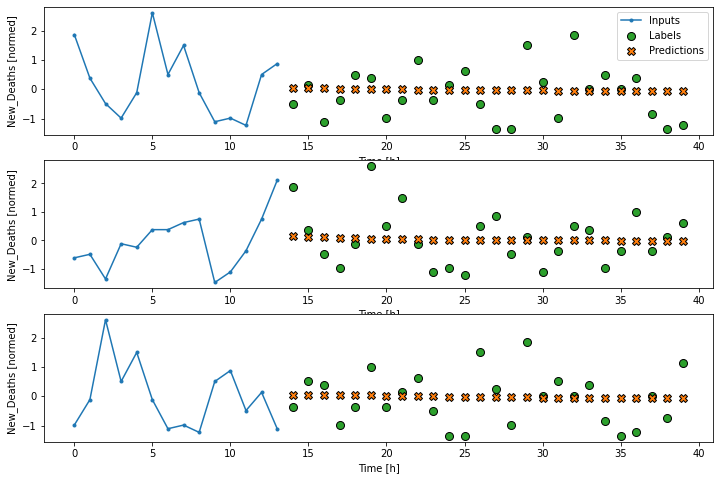

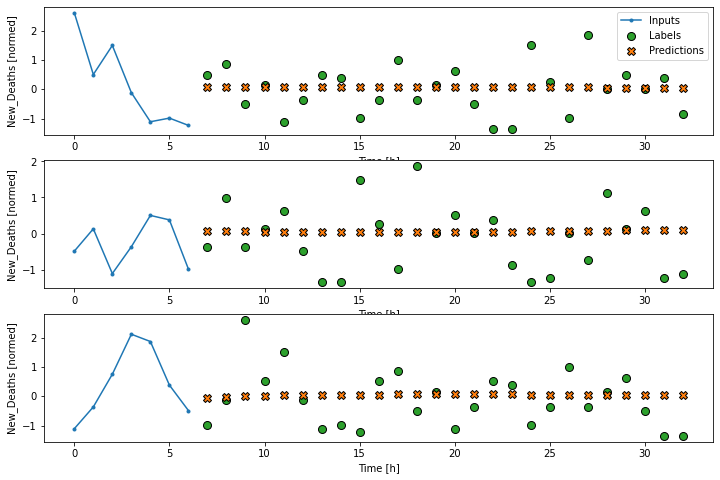

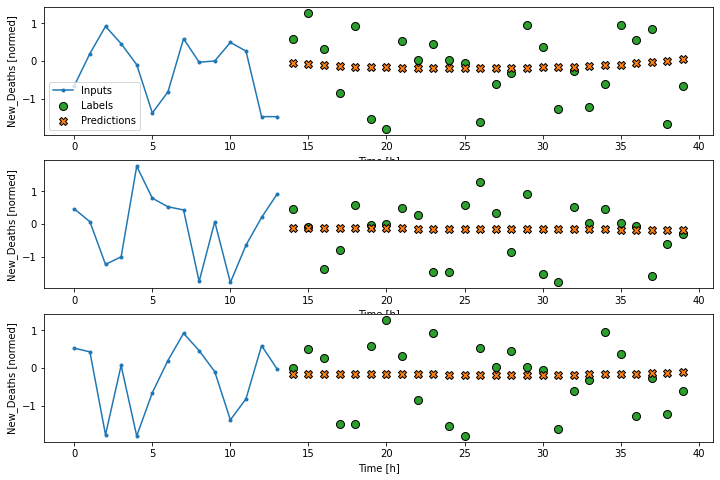

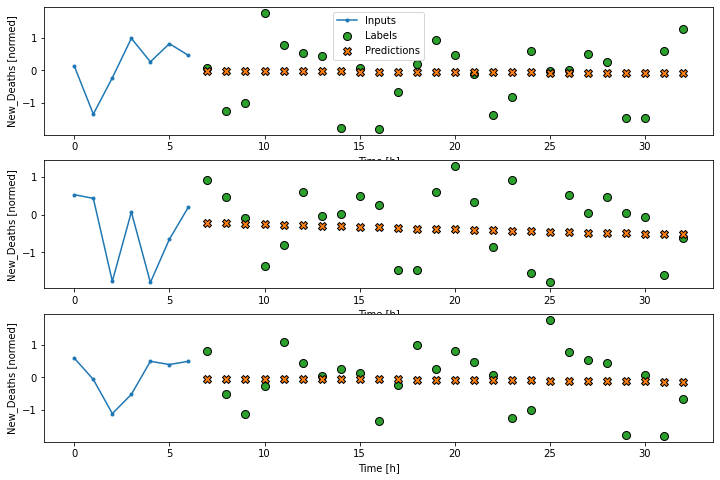

In [ ]:
df_all = pd.read_csv('cleaned_train.csv', index_col = 0)
statenames = np.unique(df_all['Province_State'])
OUT_STEPS = 26
# max epoch is tune-able
predictions = pd.DataFrame(columns = ['Province_State', 'Date', 'Confirmed', 'Deaths'])

multi_val_performance = {}
multi_performance = {}

MAPE_dict = {}

base = datetime.date(2020, 9, 1)
date_list = [base + datetime.timedelta(days=x) for x in range(26)]
for i in range(len(date_list)):
    date_list[i] = date_list[i].strftime("%m/%d/%Y")

# change state name inside list
for state in ['Alabama', 'California']:
  temp = pd.concat([pd.Series(np.repeat(state, repeats = 26)), pd.Series(date_list)], axis = 1)
  # extract state data from entire df
  statedata_all = df_all.loc[df_all['Province_State'] == state]
  statedata = statedata_all[['New_Confirmed', 'New_Deaths']]
  
  # split into training, val, test sets
  column_indices = {name: i for i, name in enumerate(df.columns)}
  n = len(statedata)
  p = 26
  train_df = statedata[0:int(n - 2*p)]
  # contains second to last set of 26 dates, tune-able
  val_df = statedata[int(n - 2*p):int(n - p)]
  # contains last 26 dates, tune-able
  test_df = statedata[int(n - p):]
  
  # standardize
  num_features = statedata.shape[1]
  train_mean = train_df.mean()
  train_std = train_df.std()

  train_df = (train_df - train_mean) / train_std
  val_df = (val_df - train_mean) / train_std
  test_df = (test_df - train_mean) / train_std
  
  # create window, input_width is number of previous days to feed in, tune-able
  multi_window = WindowGenerator(input_width=14, label_width=OUT_STEPS, shift=OUT_STEPS, 
                            train_df = train_df, val_df = val_df, test_df = test_df)
  
  # init and train model, units is number of hidden nodes, tune-able
  feedback_model = FeedBack(units=64, out_steps=OUT_STEPS)
  history = compile_and_fit(feedback_model, multi_window, 25)

  IPython.display.clear_output()

  multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val, verbose = 0)
  multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose = 0)
  # plot 3 random training performances
  multi_window.plot(feedback_model, plot_col = 'New_Deaths')
  
  # make predictions
  pred_1 = feedback_model.predict(tf.expand_dims(tf.constant(test_df), axis = 0))[0]
  for i in range(len(pred_1)):
      pred_1[i] = pred_1[i] * train_std + train_mean
  print(pred_1)

  #################################################
  ############
  # extract state data from entire df
  statedata_all = df_all.loc[df_all['Province_State'] == state]
  statedata = statedata_all[['New_Confirmed', 'New_Deaths']]
  
  # split into training, val, test sets
  column_indices = {name: i for i, name in enumerate(df.columns)}
  n = len(statedata)
  p = 26
  train_df = statedata[0:int(n - 2*p)]
  # contains second to last set of 26 dates, tune-able
  val_df = statedata[int(n - 2*p):int(n - p)]
  # contains last 26 dates, tune-able
  test_df = statedata[int(n - p):]
  
  # standardize
  num_features = statedata.shape[1]
  train_mean = train_df.mean()
  train_std = train_df.std()

  train_df = (train_df - train_mean) / train_std
  val_df = (val_df - train_mean) / train_std
  test_df = (test_df - train_mean) / train_std
  
  # create window, input_width is number of previous days to feed in, tune-able
  multi_window = WindowGenerator(input_width=7, label_width=OUT_STEPS, shift=OUT_STEPS, 
                            train_df = train_df, val_df = val_df, test_df = test_df)
  
  # init and train model, units is number of hidden nodes, tune-able
  feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)
  history = compile_and_fit(feedback_model, multi_window, 20)

  IPython.display.clear_output()

  multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val, verbose = 0)
  multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose = 0)
  # plot 3 random training performances
  multi_window.plot(feedback_model, plot_col = 'New_Deaths')
  
  # make predictions
  pred_2 = feedback_model.predict(tf.expand_dims(tf.constant(test_df), axis = 0))[0]
  for i in range(len(pred_2)):
      pred_2[i] = pred_2[i] * train_std + train_mean
  print(pred_2)

  print(pred_1[:, 0].reshape((26, 1)).shape)
  # formatting
  pred = np.concatenate((pred_1[:, 0].reshape((26, 1)), pred_2[:, 1].reshape((26, 1))), axis = 1)
  print(pred)

  pred = np.concatenate((statedata_all[['Confirmed', 'Deaths']].iloc[[len(statedata_all) - 1]], pred), axis=0).cumsum(axis = 0).round()[1:]
  print(pred)
  df2 = pd.read_csv('cleaned_test.csv', index_col = 0)
  df2 = df2.loc[df2['Province_State'] == state]
  temp = pd.concat([temp, pd.DataFrame(pred, columns = ['Confirmed', 'Deaths'])], axis = 1)
  temp.columns = ['Province_State', 'Date', 'Confirmed', 'Deaths']
  predictions = predictions.append(temp)
  # calculate MAPE for both confirmed and deaths
  mape = np.absolute((pred - np.array(df2[['Confirmed', 'Deaths']]))) / np.array(df2[['Confirmed', 'Deaths']])
  mape = np.sum(mape, axis = 0) / len(df2['Confirmed'])
  mape *= 100
  print(mape)
  

In [ ]:
pd.set_option('display.max_rows', None)
pred2 = predictions
pred2 = pred2.sort_values(by = ['Date', 'Province_State']).reset_index(drop = True)
pred2

,Province_State,Date,Confirmed,Deaths
0,Alabama,09/01/2020,126247.0,2173.0
1,California,09/01/2020,713872.0,13009.0
2,Alabama,09/02/2020,127561.0,2184.0
3,California,09/02/2020,721869.0,13081.0
4,Alabama,09/03/2020,128882.0,2196.0
5,California,09/03/2020,730026.0,13152.0
6,Alabama,09/04/2020,130211.0,2207.0
7,California,09/04/2020,738413.0,13223.0
8,Alabama,09/05/2020,131548.0,2219.0
9,California,09/05/2020,747058.0,13293.0


### Make predictions for all states

In [ ]:
import datetime
base = datetime.date(2020, 9, 1)
date_list = [base + datetime.timedelta(days=x) for x in range(26)]
for i in range(len(date_list)):
    date_list[i] = date_list[i].strftime("%m/%d/%Y")
numdays = 26

In [ ]:
df_2

In [ ]:
df_all = pd.read_csv('cleaned_train.csv', index_col = 0)
statenames = np.unique(df_all['Province_State'])
OUT_STEPS = 26

predictions = pd.DataFrame(columns = ['Province_State', 'Date', 'Confirmed', 'Deaths'])
MAPE_results_by_state = {}
for state in statenames:
  MAPE_results_by_state[state] = []

epoch_list = [15]
input_size_list = [7]
units_list = [4]
for epoch in epoch_list:
  for input in input_size_list:
    for unit in units_list:
      for state in statenames:
          print((epoch, input, unit))
          statedata_all = df_all.loc[df_all['Province_State'] == state]
          statedata = statedata_all[['New_Confirmed', 'New_Deaths']]
          
          column_indices = {name: i for i, name in enumerate(df.columns)}
          n = len(statedata)
          p = 26
          train_df = statedata[0:int(n - 2*p)]
          val_df = statedata[int(n - 2*p):int(n - p)]
          test_df = statedata[int(n - p):]

          num_features = statedata.shape[1]

          train_mean = train_df.mean()
          train_std = train_df.std()

          train_df = (train_df - train_mean) / train_std
          val_df = (val_df - train_mean) / train_std
          test_df = (test_df - train_mean) / train_std
          
          multi_window = WindowGenerator(input_width=input, label_width=OUT_STEPS, shift=OUT_STEPS, 
                                    train_df = train_df, val_df = val_df, test_df = test_df)
          
          feedback_model = FeedBack(units=unit, out_steps=OUT_STEPS)
          history = compile_and_fit(feedback_model, multi_window, epoch)

          IPython.display.clear_output()

          multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val, verbose = 0)
          multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose = 0)
          
          pred = feedback_model.predict(tf.expand_dims(tf.constant(test_df), axis = 0))[0]
          for i in range(len(pred)):
              pred[i] = pred[i] * train_std + train_mean
          
          pred = np.concatenate((statedata_all[['Confirmed', 'Deaths']].iloc[[len(statedata_all) - 1]], pred), axis=0).cumsum(axis = 0).round()[1:]
          df2 = pd.read_csv('cleaned_test.csv', index_col = 0)
          df2 = df2.loc[df2['Province_State'] == state]

          temp = pd.concat([temp, pd.DataFrame(pred, columns = ['Confirmed', 'Deaths'])], axis = 1)
          temp.columns = ['Province_State', 'Date', 'Confirmed', 'Deaths']
          predictions = predictions.append(temp)
          # mape = np.absolute((pred - np.array(df2[['Confirmed', 'Deaths']]))) / np.array(df2[['Confirmed', 'Deaths']])
          # mape = np.sum(mape, axis = 0) / len(df2['Confirmed'])
          # mape *= 100
          # print(mape)

          
      

In [ ]:
import numpy as np
def bestConfirmed(state):
  return state[3][0]
def bestDeaths(state):
  return state[3][1]

best_confirmed_MAPES = []
best_deaths_MAPES = []

for state in statenames:
  MAPE_results_by_state[state].sort(key = bestConfirmed)
  best_confirmed_MAPES.append(MAPE_results_by_state[state][0])
  if MAPE_results_by_state[state][0][3][0] > 5:
    print("Confirmed off pretty badly: ", state, " ", MAPE_results_by_state[state][0][3][0])
 
  # for i in range(5):
  #   print(MAPE_results_by_state[state][i])
  # print("=============================")
  MAPE_results_by_state[state].sort(key = bestDeaths)
  best_deaths_MAPES.append(MAPE_results_by_state[state][0])
  if MAPE_results_by_state[state][0][3][1] > 5:
    print("Deaths off pretty badly: ", state, " ", MAPE_results_by_state[state][0][3][1])
  # for i in range(5):
  #   print(MAPE_results_by_state[state][i])
  # print("")


result1, result2 = 0, 0
for i in range(len(best_confirmed_MAPES)):
  result1 += best_confirmed_MAPES[i][3][0]
  result2 += best_deaths_MAPES[i][3][1]

result1 /= 50
result2 /= 50
print(result1)
print(result2)
print(len(best_confirmed_MAPES))

In [ ]:
df_all = pd.read_csv('cleaned_train.csv', index_col = 0)
statenames = np.unique(df_all['Province_State'])
OUT_STEPS = 26

predictions = pd.DataFrame(columns = ['Province_State', 'Date', 'Confirmed', 'Deaths'])


for i, state in enumerate(statenames):
    bc_epoch, bc_input, bc_unit = best_confirmed_MAPES[i][0], best_confirmed_MAPES[i][1], best_confirmed_MAPES[i][2]
    bd_epoch, bd_input, bd_unit = best_deaths_MAPES[i][0], best_deaths_MAPES[i][1], best_deaths_MAPES[i][2]

    statedata_all = df_all.loc[df_all['Province_State'] == state]
    statedata = statedata_all[['New_Confirmed', 'New_Deaths']]
    
    column_indices = {name: i for i, name in enumerate(df.columns)}
    n = len(statedata)
    p = 26
    train_df = statedata[0:int(n - 2*p)]
    val_df = statedata[int(n - 2*p):int(n - p)]
    test_df = statedata[int(n - p):]

    num_features = statedata.shape[1]

    train_mean = train_df.mean()
    train_std = train_df.std()

    train_df = (train_df - train_mean) / train_std
    val_df = (val_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std
    
    multi_window = WindowGenerator(input_width=bc_input, label_width=OUT_STEPS, shift=OUT_STEPS, 
                              train_df = train_df, val_df = val_df, test_df = test_df)
    
    feedback_model = FeedBack(units=bc_unit, out_steps=OUT_STEPS)
    history = compile_and_fit(feedback_model, multi_window, bc_epoch)

    IPython.display.clear_output()

    multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val, verbose = 0)
    multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose = 0)
    
    pred = feedback_model.predict(tf.expand_dims(tf.constant(test_df), axis = 0))[0]
    print(pred)
    for i in range(len(pred)):
        pred[i] = pred[i] * train_std + train_mean

    pred = np.concatenate((statedata_all[['Confirmed', 'Deaths']].iloc[[len(statedata_all) - 1]], pred), axis=0).cumsum(axis = 0).round()[1:]
    
    df2 = pd.read_csv('cleaned_test.csv', index_col = 0)
    df2 = df2.loc[df2['Province_State'] == state]

  ################################# Prediction
    mape = np.absolute((pred - np.array(df2[['Confirmed', 'Deaths']]))) / np.array(df2[['Confirmed', 'Deaths']])
    mape = np.sum(mape, axis = 0) / len(df2['Confirmed'])
    mape *= 100
    print(mape)



In [ ]:
pred2.to_csv("Team1_LSTM.csv")

## Archived Code

We will add a parameter for the number of days since Jan 1st, which will eventually replace the timestamps.


In [ ]:
df_all = pd.read_csv('cleaned_train.csv', index_col = 0)
statenames = ['Arkansas', 'Hawaii', 'Kansas', 'Kentucky', 
              'Missouri', 'Montana', 'North Dakota', 'Oklahoma', 'South Dakota', 'Texas',
              'West Virginia', 'Wisconsin']
OUT_STEPS = 26

predictions = pd.DataFrame(columns = ['Province_State', 'Date', 'Confirmed', 'Deaths'])
MAPE_results_by_state_new = {}
for state in statenames:
  MAPE_results_by_state_new[state] = []

epoch_list = [15, 20, 25]
input_size_list = [4, 7, 10, 14, 21]
units_list = [4, 8, 16, 32]
for epoch in epoch_list:
  for input in input_size_list:
    for unit in units_list:
      for state in statenames:
          
          statedata_all = df_all.loc[df_all['Province_State'] == state]
          statedata = statedata_all[['New_Confirmed', 'New_Deaths']]
          
          column_indices = {name: i for i, name in enumerate(df.columns)}
          n = len(statedata)
          p = 26
          train_df = statedata[0:int(n - 2*p)]
          val_df = statedata[int(n - 2*p):int(n - p)]
          test_df = statedata[int(n - p):]

          num_features = statedata.shape[1]

          train_mean = train_df.mean()
          train_std = train_df.std()

          train_df = (train_df - train_mean) / train_std
          val_df = (val_df - train_mean) / train_std
          test_df = (test_df - train_mean) / train_std
          
          multi_window = WindowGenerator(input_width=input, label_width=OUT_STEPS, shift=OUT_STEPS, 
                                    train_df = train_df, val_df = val_df, test_df = test_df)
          
          feedback_model = FeedBack(units=unit, out_steps=OUT_STEPS)
          history = compile_and_fit(feedback_model, multi_window, epoch)

          IPython.display.clear_output()

          multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val, verbose = 0)
          multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose = 0)
          
          pred = feedback_model.predict(tf.expand_dims(tf.constant(test_df), axis = 0))[0]
          for i in range(len(pred)):
              pred[i] = pred[i] * train_std + train_mean

          pred = np.concatenate((statedata_all[['Confirmed', 'Deaths']].iloc[[len(statedata_all) - 1]], pred), axis=0).cumsum(axis = 0).round()[1:]
          df2 = pd.read_csv('cleaned_test.csv', index_col = 0)
          df2 = df2.loc[df2['Province_State'] == state]

          mape = np.absolute((pred - np.array(df2[['Confirmed', 'Deaths']]))) / np.array(df2[['Confirmed', 'Deaths']])
          mape = np.sum(mape, axis = 0) / len(df2['Confirmed'])
          mape *= 100
          print(mape)

          MAPE_results_by_state_new[state].append((epoch, input, unit, mape))
  
best_confirmed_MAPES_new = []
best_deaths_MAPES_new = []

for state in statenames:
  MAPE_results_by_state_new[state].sort(key = bestConfirmed)
  best_confirmed_MAPES_new.append(MAPE_results_by_state[state][0])
  if MAPE_results_by_state_new[state][0][3][0] > 5:
    print("Confirmed off pretty badly: ", state, " ", MAPE_results_by_state_new[state][0][3][0])
 
  # for i in range(5):
  #   print(MAPE_results_by_state[state][i])
  # print("=============================")
  MAPE_results_by_state_new[state].sort(key = bestDeaths)
  best_deaths_MAPES_new.append(MAPE_results_by_state[state][0])
  if MAPE_results_by_state_new[state][0][3][1] > 5:
    print("Deaths off pretty badly: ", state, " ", MAPE_results_by_state_new[state][0][3][1])
  # for i in range(5):
  #   print(MAPE_results_by_state[state][i])
  # print("")


result1, result2 = 0, 0
for i in range(len(best_confirmed_MAPES_new)):
  result1 += best_confirmed_MAPES_new[i][3][0]
  result2 += best_deaths_MAPES_new[i][3][1]

result1 /= 12
result2 /= 12
print(result1)
print(result2)